In [1]:
import pandas as pd
import psycopg2 as pg2

database = 'arch-snap_gplus-scale-1'
conn = pg2.connect("host='localhost'  port=5422 password='yuchao' dbname=%s"%database)

/home/yuchao/.local/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
sql = "SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema';"
pd.read_sql(sql, conn)

,schemaname,tablename,tableowner,tablespace,hasindexes,hasrules,hastriggers,rowsecurity
0,public,circles,duke,None,False,False,False,False
1,public,edges,duke,None,False,False,False,False
2,public,combined,duke,None,False,False,False,False


In [29]:
sql = '''
SELECT
   TABLE_NAME, COLUMN_NAME
FROM
   information_schema.COLUMNS
   JOIN
       (SELECT * FROM pg_catalog.pg_tables WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema') AS tables
    ON tables.tablename = table_name
'''
pd.read_sql(sql, conn)

,table_name,column_name
0,circles,source
1,circles,circle
2,circles,node
3,edges,source
4,edges,fnode
5,edges,tnode
6,combined,fnode
7,combined,tnode


In [2]:
sql = "SELECT * FROM circles;"
pd.read_sql(sql, conn)

,source,circle,node
0,106837574755355833243,RdFJugCK9y9,116135963476096063106
1,106837574755355833243,RdFJugCK9y9,113895757504658643526
2,106837574755355833243,RdFJugCK9y9,107830973724615314405
3,106837574755355833243,RdFJugCK9y9,110931028315248759176
4,106837574755355833243,RdFJugCK9y9,108968814832775860185
...,...,...,...
63058,100521671383026672718,hkCJSywrcCa,101995000136632349501
63059,100521671383026672718,hkCJSywrcCa,104979143639484917985
63060,100521671383026672718,hkCJSywrcCa,111262585178145220797
63061,100521671383026672718,hkCJSywrcCa,106192011591840077787


In [3]:
sql = "SELECT * FROM edges;"
pd.read_sql(sql, conn)

,source,fnode,tnode
0,106837574755355833243,114302252107350810618,101143361848178827946\n
1,106837574755355833243,107519234035124447222,111551895671908911144\n
2,106837574755355833243,104751957560162245889,103002075844443596313\n
3,106837574755355833243,114021536527450214647,107040353898400532534\n
4,106837574755355833243,100889954092674838350,113272089205540715298\n
...,...,...,...
30238030,100521671383026672718,104997986368838301110,108972509678555833657\n
30238031,100521671383026672718,107681128997061691267,116908343245369871265\n
30238032,100521671383026672718,115969526432644857600,110442590930631703783\n
30238033,100521671383026672718,102606322731970268005,115932838014733798588\n


In [94]:
sql = "SELECT count(*) FROM circles group by source, circle;"
pd.read_sql(sql, conn)

,count
0,21
1,22
2,1
3,3
4,1
...,...
188,4
189,1
190,4
191,4


In [31]:
sql = "SELECT * FROM edges;"
pd.read_sql(sql, conn)

,source,fnode,tnode
0,0,236,186
1,0,122,285
2,0,24,346
3,0,271,304
4,0,176,9
...,...,...,...
170169,414,594,563
170170,414,653,597
170171,414,584,679
170172,414,600,628


In [4]:
sql = "SELECT * FROM combined;"
pd.read_sql(sql, conn)

DatabaseError: Execution failed on sql: SELECT * FROM combined;
terminating connection due to administrator command
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.

unable to rollback

In [23]:
# Count how many nodes appearing in circles
# Document: Nodes 4039
sql = '''
select count(distinct node) from circles;
'''
pd.read_sql(sql, conn)

,count
0,2884


In [26]:
# Count how many nodes appearing in edges
# Document: Nodes 4039
sql = '''
select count(distinct node) from (select fnode as node from edges UNION select tnode as node from edges) AS nodes;
'''
pd.read_sql(sql, conn)

,count
0,3959


In [40]:
# Count how many nodes appearing in combined
# Document: Nodes 4039
sql = '''
select count(distinct node) from (select fnode as node from combined UNION select tnode as node from combined) AS nodes;
'''
pd.read_sql(sql, conn)

,count
0,4039


In [36]:
# Count the unique edges
# Document: Edges 88234
sql = "SELECT COUNT(*) FROM (SELECT 1 FROM edges GROUP BY fnode, tnode) as uni;"
pd.read_sql(sql, conn)

,count
0,168486


In [12]:
# Count the union of edges and reversed edges
# Document: Edges 88234
sql = '''
WITH undirected_edges AS (SELECT * from edges UNION SELECT source, tnode as fnode, fnode as tnode from edges)
select count(*) from undirected_edges;
'''
pd.read_sql(sql, conn)

,count
0,170174


In [15]:
# Count the union of edges and reversed edges from combined
# Document: Edges 88234
sql = '''
WITH undirected_edges AS (SELECT * from combined UNION SELECT tnode as fnode, fnode as tnode from combined) 
select count(*) from undirected_edges;
'''
pd.read_sql(sql, conn)

,count
0,176468


In [16]:
# Count how many edges are the same in reverse
sql = '''
select count(*) from edges as e1 join edges as e2 on e1.fnode = e2.tnode AND e1.tnode = e2.fnode AND e1.source = e2.source;
'''
pd.read_sql(sql, conn)

,count
0,170174


In [17]:
# Count how many edges are the same in reverse without source restriction
sql = '''
select count(*) from edges as e1 join edges as e2 on e1.fnode = e2.tnode AND e1.tnode = e2.fnode;
'''
pd.read_sql(sql, conn)

,count
0,173634


In [5]:
# Count how many edges from combined are the same in reverse
sql = '''
select count(*) from combined as e1 join combined as e2 on e1.fnode = e2.tnode AND e1.tnode = e2.fnode;
'''
pd.read_sql(sql, conn)

,count
0,0


In [38]:
# Count the unique edges from combined
# Document: Edges 88234
sql = "SELECT COUNT(*) FROM (SELECT 1 FROM combined GROUP BY fnode, tnode) as uni;"
pd.read_sql(sql, conn)

,count
0,88234


In [21]:
# Count triangles from the same source
# Document: Number of triangles 1612010
sql = '''
select count(*) from edges as e1, edges as e2, edges as e3 WHERE e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode AND e1.source = e2.source AND e2.source = e3.source;
'''
pd.read_sql(sql, conn)

,count
0,9195840


In [22]:
# Count triangles
# Document: Number of triangles 1612010
sql = '''
select count(*) from edges as e1, edges as e2, edges as e3 WHERE e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode;
'''
pd.read_sql(sql, conn)

,count
0,9491958


In [16]:
# Count triangles
# Document: Number of triangles 1612010
sql = '''
WITH undirected_combined as (SELECT * from combined UNION select tnode as fnode, fnode as tnode from combined)
select count(*)/6 from undirected_combined as e1, undirected_combined as e2, undirected_combined as e3 WHERE e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode;
'''
pd.read_sql(sql, conn)

,?column?
0,1612010


In [7]:
# Test Union
sql = '''
select * from combined limit 1;
'''
pd.read_sql(sql, conn)

,fnode,tnode
0,0,1


In [11]:
# Test Union
sql = '''
(select tnode as fnode, fnode as tnode from combined limit 1)
UNION
(select * from combined limit 1);
'''
pd.read_sql(sql, conn)

,fnode,tnode
0,0,1
1,1,0


In [ ]:
# Count how many triangles such that all individuals share the common friend, and each of edge from different circle
# Output:
# source, circle 1, circle 2, circle 3, triangles
sql = '''
WITH full_info AS (
    SELECT 
        edges.source, fnode, c1.circle as fcircle, tnode, c2.circle as tcircle 
    FROM
        edges, circles c1, circles c2 where edges.source = c1.source AND edges.source = c2.source AND edges.fnode = c1.node AND edges.tnode = c2.node
)
select 
    count(*) 
from 
    full_info e1, full_info e2, full_info e3
WHERE
    e1.fcircle = e1.tcircle
    AND e2.fcircle = e2.tcircle
    AND e3.fcircle = e3.tcircle
    AND e1.fcircle <> e2.fcircle
    AND e2.fcircle <> e3.fcircle
    AND e1.fcircle <> e3.fcircle
    AND e1.source = e2.source
    AND e2.source = e3.source
    AND e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode
    ;
'''
pd.read_sql(sql, conn)

In [5]:
# Count how many triangles such that all individuals share the common friend, and each of edge from different circle
# Output:
# source, circle 1, circle 2, circle 3, triangles
sql = '''
WITH full_info AS (
    SELECT 
        edges.source, fnode, c1.circle as fcircle, tnode, c2.circle as tcircle 
    FROM
        edges, circles c1, circles c2 
    where edges.source = c1.source AND edges.source = c2.source AND edges.fnode = c1.node AND edges.tnode = c2.node
        AND c1.source = c2.source       
)
select 
    count(*) 
from 
    full_info e1, full_info e2, full_info e3
WHERE
    True
    AND e1.fcircle < e2.fcircle
    AND e2.fcircle < e3.fcircle
    AND e1.source = e2.source
    AND e2.source = e3.source
    AND e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode
    ;
'''
pd.read_sql(sql, conn)

,count
0,63679680


In [98]:
# Count how many triangles such that all individuals share the common friend, and each of edge from different circle
# Output:
# source, circle 1, circle 2, circle 3, triangles
sql = '''
WITH full_info AS (
    SELECT 
        edges.source, fnode, c1.circle as fcircle, tnode, c2.circle as tcircle 
    FROM
        edges, circles c1, circles c2 
    where edges.source = c1.source AND edges.source = c2.source AND edges.fnode = c1.node AND edges.tnode = c2.node
        AND c1.circle = c2.circle       
)
select 
    e1.source as source, e1.fcircle as circle1, e2.fcircle as circle2, e3.fcircle as circle3, count(*) as cnt 
from 
    full_info e1, full_info e2, full_info e3
WHERE
    True
    AND e1.fcircle < e2.fcircle
    AND e2.fcircle < e3.fcircle
    AND e1.source = e2.source
    AND e2.source = e3.source
    AND e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode
GROUP BY
    e1.source, e1.fcircle, e2.fcircle, e3.fcircle
;
'''
triangles = pd.read_sql(sql, conn)

In [4]:
triangles.groupby(['source'])['cnt'].agg('sum')

source
348     63483
414        24
686     38563
698        24
1912     4236
3437      134
Name: cnt, dtype: int64

In [30]:
triangles.sort_values(['cnt'], ascending=False)

,source,circle1,circle2,circle3,cnt
44,348,1,11,13,20751
20,348,1,2,11,10366
38,348,1,8,11,9374
4,348,0,1,11,8610
102,686,0,4,13,6235
...,...,...,...,...,...
298,1912,21,35,40,1
266,1912,10,35,43,1
12,348,0,7,13,1
9,348,0,2,13,1


In [31]:
with pd.option_context("display.max_rows", 1000):
    display(triangles.query('cnt > 1000').sort_values(['cnt'], ascending=False))

,source,circle1,circle2,circle3,cnt
44,348,1,11,13,20751
20,348,1,2,11,10366
38,348,1,8,11,9374
4,348,0,1,11,8610
102,686,0,4,13,6235
99,686,0,4,9,4744
101,686,0,4,12,3800
189,686,4,9,13,3719
40,348,1,8,13,2270
120,686,0,9,13,1844


In [99]:
# Count how many triangles such that all individuals share the common friend, and each of edge from different circle
# Output:
# source, circle 1, circle 2, circle 3, triangles
sql = '''SELECT e1.source as ego1, e2.source ego2, e3.source ego3, count(*) as triangles FROM edges e1, edges e2, edges e3
    WHERE e1.source < e2.source AND e2.source < e3.source
    AND e1.tnode = e2.fnode AND e2.tnode = e3.fnode AND e3.tnode = e1.fnode
GROUP BY
    e1.source, e2.source, e3.source
;
'''
triangles_ego = pd.read_sql(sql, conn)

In [100]:
triangles_ego.sort_values(['triangles'], ascending=False)

,ego1,ego2,ego3,triangles
1,107,348,414,2899
4,348,414,1912,32
2,107,348,1912,6
3,107,414,1912,6
0,0,107,1684,3


In [7]:
#!/usr/bin/python3

%load_ext autoreload
%autoreload 2

from run import run_TSens, run_Elastic, run_LTSens, run_Query, run_PrivateSQL, run_TSensDP
from algo import gen_report_title, gen_query_report_title
from objects import Relation
from dp import DP_TSens, DP_PrivateSQL
import dp
from import_schema import read_schema_from_file
from import_hypertree import read_hypertree_from_file

arch = 'snap_facebook'
scale = '1'

def test_q1():
    run_TSens(arch, scale, q='q1', reps=2)

In [18]:
run_TSens(arch, scale, q='q1', reps=10)

algorithm: TSens
arch-snap_facebook-scale-1
query:  q1
Time Elapsed: 0.105
--------------------
The most sensitive tuple is
- Relation:  source_348_circle_13
- Tuple:  [('a', 376), ('c', 376)]
- sensitivity:  76

The most sensitive tuple for each table
(source_348_circle_13, [('a', 376), ('c', 376)], 76)
(source_348_circle_11, [('b', 376), ('c', 376)], 50)
(source_348_circle_1, [('a', 376), ('b', 376)], 33)
- Test Result:  Succeeded



In [19]:
run_Query(arch, scale, q='q1', reps=10)

snap_facebook | 1 | q1 | 20751 | 0.062 | [0.07512497901916504, 0.06048297882080078, 0.05781841278076172, 0.05793261528015137, 0.059337615966796875, 0.06261467933654785, 0.05746006965637207, 0.06490707397460938, 0.06363701820373535, 0.060750484466552734] | Unknown


In [20]:
run_Elastic(arch, scale, q='q1', reps=10)

algorithm: Elastic
arch-snap_facebook-scale-1
query:  q1
Time Elapsed: 0.008
--------------------
The most sensitive tuple is
- Relation:  source_348_circle_13
- Tuple:  [('A', 376), ('C', 376)]
- sensitivity:  7524

The most sensitive tuple for each table
(source_348_circle_13, [('A', 376), ('C', 376)], 7524, 76)
(source_348_circle_11, [('C', 376), ('B', 376)], 4950, 50)
(source_348_circle_1, [('A', 376), ('B', 376)], 3800, 33)
- Test Result:  Unknown



In [15]:
run_LTSens(arch, scale, q='q1', report=None, reps=1)

In [26]:
run_TSensDP(arch, scale, q='q1', reln=Relation('any', 'source_348_circle_11', {}), limit=100, eps=1, reps=10)

arch: snap_facebook, scale: 1, query: q1
algo_name: TSensDP, reps: 10
private reln: source_348_circle_11, eps: 1
nosy_ans: 19626.845, gsens: 60, bias_ans: 19639, true_ans: 20751
mean relative error: 0.059
mean relative bias: 0.054
eps: 1.000, pre_eps: 0.500, run_eps: 0.500
nosy_ans_list: [20458.714276527713, 20640.865226845093, 14306.154278410468, 21157.0765879018, 17859.232822238693, 19739.30941872518, 20635.972822634838, 20840.33471230281, 20507.06459810313, 20123.722208979205]
bias_ans_list: [20751.0, 20601.0, 14251.0, 20751.0, 17930.0, 19813.0, 20601.0, 20751.0, 20751.0, 20191.0]
gsens_list: [107, 31, 18, 63, 22, 26, 31, 165, 118, 27]


In [27]:
run_PrivateSQL(arch, scale, q='q1', reln=Relation('any', 'source_348_circle_11', {}), limit=1000, eps=1, reps=10)

/home/BigDATA/TupleSens/dp.py:12: RuntimeWarning: divide by zero encountered in true_divide
  DIV = Infix(lambda x,y: np.divide(x,y))


arch: snap_facebook, scale: 1, query: q1
algo_name: PrivateSQL, reps: 10
private reln: source_348_circle_11, eps: 1
nosy_ans: 23122.449, gsens: 4950, bias_ans: 20751, true_ans: 20751
mean relative error: 0.219
mean relative bias: 0.000
eps: 1.000, pre_eps: 0.500, run_eps: 0.500
nosy_ans_list: [21388.805757419912, 21821.017231234287, 20735.49499555457, 17798.234552460628, 30490.463477874928, 26001.38933471729, 20590.491970420822, 23303.64162490454, 13010.123310997315, 36084.82880115944]
bias_ans_list: [20751, 20751, 20751, 20751, 20751, 20751, 20751, 20751, 20751, 20751]
gsens_list: [4950, 4950, 4950, 4950, 4950, 4950, 4950, 4950, 4950, 4950]


In [86]:
import sys

from algo import gen_report_title, gen_query_report_title
import dp

top_triangles_csv = './data/snap/facebook/top_triangles.csv'
top_triangles = pd.read_csv(top_triangles_csv)

reps = 10

def run_sens():
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    gen_report_title()
    for _, triangle in top_triangles.iterrows():
        qname = 'q{source}_{circle1}_{circle2}_{circle3}_{cnt}'.format(**triangle)
        run_TSens(arch, scale, q=qname, reps=reps, report='file')
        run_Elastic(arch, scale, q=qname, reps=reps, report='file')
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report

def run_query():
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    gen_query_report_title()
    for _, triangle in top_triangles.iterrows():
        qname = 'q{source}_{circle1}_{circle2}_{circle3}_{cnt}'.format(**triangle)
        run_Query(arch, scale, q=qname, reps=reps, report='query')
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report

def run_DP():
    old_stdout = sys.stdout
    sys.stdout = open('/tmp/report', 'w')
    dp.gen_report_title()
    for _, triangle in top_triangles.iterrows():
        qname = 'q{source}_{circle1}_{circle2}_{circle3}_{cnt}'.format(**triangle)
        limit = 100
        eps = 1.0
        exclusion = []
        reln = Relation('any', 'source_{source}_circle_{circle1}'.format(**triangle), {})
        run_LTSens(arch, scale, q=qname, exclusion=exclusion, report=None, reps=1)
        run_TSensDP(arch, scale, qname, reln, limit, eps, report='file', reps=reps)
        run_PrivateSQL(arch, scale, qname, reln, None, eps, report='file', reps=reps)
    sys.stdout = old_stdout
    report = pd.read_csv('/tmp/report', sep=r' \| ', engine='python')
    return report 

report_sens = run_sens()
report_query = run_query()
report_DP = run_DP()

/home/BigDATA/TupleSens/dp.py:12: RuntimeWarning: divide by zero encountered in true_divide
  DIV = Infix(lambda x,y: np.divide(x,y))


In [91]:
display(report_sens)

,algo,arch,scale,query,time,relation,tuple,sensitivity,all_table_tstar,time_list,test pass
0,TSens,snap_facebook,1,q348_0_1_8_1063,0.022,source_348_circle_0,"[('a', 376), ('b', 376)]",30,"[(source_348_circle_0, [('a', 376), ('b', 376)...","[0.02411341667175293, 0.02169513702392578, 0.0...",Succeeded
1,Elastic,snap_facebook,1,q348_0_1_8_1063,0.004,source_348_circle_0,"[('A', 373), ('B', 373)]",2970,"[(source_348_circle_0, [('A', 373), ('B', 373)...","[0.005485057830810547, 0.0039975643157958984, ...",Unknown
2,TSens,snap_facebook,1,q348_0_1_11_8610,0.084,source_348_circle_0,"[('a', 376), ('b', 376)]",76,"[(source_348_circle_0, [('a', 376), ('b', 376)...","[0.0854952335357666, 0.08375072479248047, 0.08...",Succeeded
3,Elastic,snap_facebook,1,q348_0_1_11_8610,0.006,source_348_circle_0,"[('A', 373), ('B', 376)]",7524,"[(source_348_circle_0, [('A', 373), ('B', 376)...","[0.0063953399658203125, 0.005421161651611328, ...",Unknown
4,TSens,snap_facebook,1,q348_0_1_13_1468,0.038,source_348_circle_0,"[('a', 376), ('b', 376)]",50,"[(source_348_circle_0, [('a', 376), ('b', 376)...","[0.037980079650878906, 0.0359797477722168, 0.0...",Succeeded
5,Elastic,snap_facebook,1,q348_0_1_13_1468,0.005,source_348_circle_0,"[('A', 376), ('B', 376)]",4950,"[(source_348_circle_0, [('A', 376), ('B', 376)...","[0.0056743621826171875, 0.004650592803955078, ...",Unknown
6,TSens,snap_facebook,1,q348_0_11_13_1104,0.027,source_348_circle_0,"[('a', 376), ('b', 376)]",33,"[(source_348_circle_0, [('a', 376), ('b', 376)...","[0.028392791748046875, 0.02724909782409668, 0....",Succeeded
7,Elastic,snap_facebook,1,q348_0_11_13_1104,0.004,source_348_circle_0,"[('A', 373), ('B', 373)]",3800,"[(source_348_circle_0, [('A', 373), ('B', 373)...","[0.005162477493286133, 0.0040435791015625, 0.0...",Unknown
8,TSens,snap_facebook,1,q348_1_2_11_10366,0.083,source_348_circle_2,"[('b', 376), ('c', 376)]",76,"[(source_348_circle_2, [('b', 376), ('c', 376)...","[0.08549189567565918, 0.08210134506225586, 0.0...",Succeeded
9,Elastic,snap_facebook,1,q348_1_2_11_10366,0.006,source_348_circle_2,"[('C', 376), ('B', 404)]",7524,"[(source_348_circle_2, [('C', 376), ('B', 404)...","[0.006688356399536133, 0.0055484771728515625, ...",Unknown


In [92]:
display(report_query)

,arch,scale,query,toal_cnt,avg_time,time_list,test_pass
0,snap_facebook,1,q348_0_1_8_1063,1063,0.031,"[0.04255485534667969, 0.028239011764526367, 0....",Unknown
1,snap_facebook,1,q348_0_1_11_8610,8610,0.045,"[0.04505133628845215, 0.03908181190490723, 0.0...",Unknown
2,snap_facebook,1,q348_0_1_13_1468,1468,0.032,"[0.0393834114074707, 0.03069138526916504, 0.03...",Unknown
3,snap_facebook,1,q348_0_11_13_1104,1104,0.032,"[0.035523176193237305, 0.02820134162902832, 0....",Unknown
4,snap_facebook,1,q348_1_2_11_10366,10366,0.045,"[0.046982765197753906, 0.04510903358459473, 0....",Unknown
5,snap_facebook,1,q348_1_8_11_9374,9374,0.043,"[0.04923439025878906, 0.0416102409362793, 0.04...",Unknown
6,snap_facebook,1,q348_1_8_13_2270,2270,0.033,"[0.03655219078063965, 0.033670663833618164, 0....",Unknown
7,snap_facebook,1,q348_1_9_11_1212,1212,0.032,"[0.04745316505432129, 0.029022216796875, 0.035...",Unknown
8,snap_facebook,1,q348_1_11_13_20751,20751,0.063,"[0.07455992698669434, 0.06460928916931152, 0.0...",Unknown
9,snap_facebook,1,q348_8_11_13_1557,1557,0.032,"[0.04132795333862305, 0.03480195999145508, 0.0...",Unknown


In [89]:
display(report_DP)

,algo,arch,scale,query,reln,limit,reps,eps,pre_eps,run_eps,nosy_ans,gsens,bias_ans,true_ans,nosy_ans_list,bias_ans_list,gsens_list,error
0,TSensDP,snap_facebook,1,q348_0_1_8_1063,source_348_circle_0,100,10,1.0,0.5,0.5,659.657583,69.7,732.7,1063.0,"[786.2163343171544, -2.1607024317930255, 1223....","[1063.0, 0.0, 1063.0, 949.0, 0.0, 1063.0, 1063...","[73, 1, 116, 17, 1, 69, 190, 83, 1, 146]",0.379438
1,PrivateSQL,snap_facebook,1,q348_0_1_8_1063,source_348_circle_0,None,10,1.0,0.5,0.5,2898.665891,2970.0,1063.0,1063.0,"[5171.731881766781, 1502.3617089560746, -2044....","[1063, 1063, 1063, 1063, 1063, 1063, 1063, 106...","[2970, 2970, 2970, 2970, 2970, 2970, 2970, 297...",1.726873
2,TSensDP,snap_facebook,1,q348_0_1_11_8610,source_348_circle_0,100,10,1.0,0.5,0.5,7579.430916,63.0,7614.0,8610.0,"[8635.063890825833, 8281.850293447911, 3597.35...","[8610.0, 8364.0, 3646.0, 7514.0, 8610.0, 6634....","[62, 57, 37, 50, 80, 46, 54, 130, 64, 50]",0.119694
3,PrivateSQL,snap_facebook,1,q348_0_1_11_8610,source_348_circle_0,None,10,1.0,0.5,0.5,4712.818095,7524.0,8610.0,8610.0,"[34449.16481258069, 10497.043635988948, 9892.2...","[8610, 8610, 8610, 8610, 8610, 8610, 8610, 861...","[7524, 7524, 7524, 7524, 7524, 7524, 7524, 752...",0.452634
4,TSensDP,snap_facebook,1,q348_0_1_13_1468,source_348_circle_0,100,10,1.0,0.5,0.5,1039.197875,41.1,1056.9,1468.0,"[1381.8924981073715, 1507.2367127341709, 1472....","[1468.0, 1468.0, 1468.0, 1468.0, 4.0, 0.0, 146...","[47, 55, 65, 66, 4, 1, 67, 19, 66, 21]",0.292100
5,PrivateSQL,snap_facebook,1,q348_0_1_13_1468,source_348_circle_0,None,10,1.0,0.5,0.5,-4596.308832,4950.0,1468.0,1468.0,"[-19235.973836868474, -10849.388635596393, -17...","[1468, 1468, 1468, 1468, 1468, 1468, 1468, 146...","[4950, 4950, 4950, 4950, 4950, 4950, 4950, 495...",4.131001
6,TSensDP,snap_facebook,1,q348_0_11_13_1104,source_348_circle_0,100,10,1.0,0.5,0.5,528.172926,34.1,554.4,1104.0,"[15.405635636353507, 1117.3600687554742, 1004....","[14.0, 1104.0, 1104.0, 0.0, 216.0, 1104.0, 0.0...","[5, 155, 68, 1, 10, 53, 1, 21, 1, 26]",0.521582
7,PrivateSQL,snap_facebook,1,q348_0_11_13_1104,source_348_circle_0,None,10,1.0,0.5,0.5,6476.818706,3800.0,1104.0,1104.0,"[4651.655133844991, -9120.246583820513, 1413.0...","[1104, 1104, 1104, 1104, 1104, 1104, 1104, 110...","[3800, 3800, 3800, 3800, 3800, 3800, 3800, 380...",4.866684
8,TSensDP,snap_facebook,1,q348_1_2_11_10366,source_348_circle_1,100,10,1.0,0.5,0.5,9231.701540,36.4,9271.4,10366.0,"[10342.320582290651, 10304.371236675608, 6498....","[10366.0, 10366.0, 6662.0, 10366.0, 10366.0, 1...","[42, 21, 14, 54, 90, 54, 16, 14, 17, 42]",0.109425
9,PrivateSQL,snap_facebook,1,q348_1_2_11_10366,source_348_circle_1,None,10,1.0,0.5,0.5,8599.072258,1824.0,10366.0,10366.0,"[6924.836066996565, 16787.5329806649, 10721.54...","[10366, 10366, 10366, 10366, 10366, 10366, 103...","[1824, 1824, 1824, 1824, 1824, 1824, 1824, 182...",0.170454


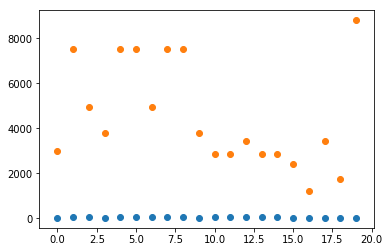

In [87]:
import matplotlib.pyplot as plt

df = report_sens.query('algo == "TSens"')
x = df['query']
y = df['sensitivity']
plt.scatter(list(range(len(y))), y)
df = report_sens.query('algo == "Elastic"')
x = df['query']
y = df['sensitivity']
plt.scatter(list(range(len(y))), y)
plt.show()

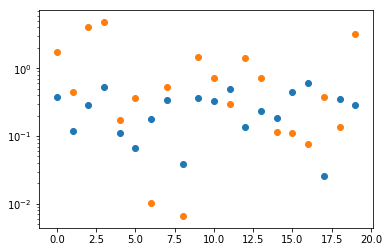

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def show_DP(algo):
    df = report_DP
    df['error'] = np.absolute(df['nosy_ans'] - df['true_ans']) / df['true_ans']
    df = df.query('algo == "{algo}"'.format(algo=algo))
    y = df['error']
    plt.scatter(list(range(len(y))), y)
    
plt.yscale('log')
show_DP('TSensDP')
show_DP('PrivateSQL')
plt.show()

In [66]:
report_sens.columns

Index(['algo ', ' arch ', ' scale ', ' query ', ' time ', ' relation ',
       ' tuple ', ' sensitivity ', ' all_table_tstar ', ' time_list ',
       ' test pass'],
      dtype='object')